In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [10]:
data = pd.read_excel("../data/TBS_data.xlsx", sheet_name='야드크레이인_작업이력')
scd_data = pd.read_excel("../data/TBS_data.xlsx", sheet_name='반출입_예정컨테이너')
cbd_data = pd.read_excel("../data/TBS_data.xlsx", sheet_name='장치장_전')
cad_data = pd.read_excel("../data/TBS_data.xlsx", sheet_name='장치장_후')
quay_work_data = pd.read_excel("../data/TBS_data.xlsx", sheet_name='본선크레인_작업이력')

# int 타입임
print(quay_work_data['작업완료시간'].dtype)
quay_work_data['작업완료시간'] = quay_work_data['작업완료시간'].astype(str).replace('^2020', '2023', regex=True)


# data, container_before_data, container_after_data merge
ycb_common_values = data['컨테이너번호'].isin(quay_work_data['컨테이너번호']).sum() # 6103개
print('ycb_common_values', ycb_common_values)
yard_con_common_df = pd.merge(data, quay_work_data, on='컨테이너번호')
print(yard_con_common_df)
print(yard_con_common_df.columns)
common_df = yard_con_common_df

int64
ycb_common_values 3212
           컨테이너번호 작업코드_x 선박코드_x  년도_x  항차_x  블록    베이   로우   티어 블록2  ...   
0     ZZDZ6311334     VL   CAET  2023    11  3H  12.0  3.0  3.0  3H  ...  \
1     KLIS7104372     TS   PCHM  2023     4  3F  18.0  5.0  3.0  3F  ...   
2     KLIS7104372     TS   PCHM  2023     4  3F  18.0  4.0  1.0  3F  ...   
3     KLIS7104372     TS   PCHM  2023     4  3F  18.0  5.0  3.0  3F  ...   
4     KLIS7104372     TS   PCHM  2023     4  3F  18.0  4.0  1.0  3F  ...   
...           ...    ...    ...   ...   ...  ..   ...  ...  ...  ..  ...   
3207  QIVW6634573     VL   NSSK  2023     8  5A  21.0  6.0  3.0  5A  ...   
3208  YTHZ7596295     VL   PCHM  2023     4  4D  19.0  3.0  1.0  4D  ...   
3209  CFNG7024213     VU   DJVS  2023    12  5A  21.0  NaN  NaN  5A  ...   
3210  OFGG4630734     VU   DJVS  2023    12  5A  21.0  NaN  NaN  5A  ...   
3211  VNCL0771568     VU   DJVS  2023    12  3H   3.0  NaN  NaN  3H  ...   

      항차_y  안벽장비\n번호  해치순서  베이순서 홀드/데크  해치번호        작업완료시간

In [11]:
# 데이터 전처리
common_df['작업코드_x'] = common_df['작업코드_x'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})

# 외부트럭에 1 넣기
common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)

# print('n_data', n_data)
print('common_df',common_df.info())
# print(n_data.isna().sum())

# 시간 타입 통합
common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
common_df['작업완료시간_x'] = pd.to_datetime(common_df['작업완료시간_x'], format='%Y%m%d%H%M%S')
common_df['작업완료시간_y'] = pd.to_datetime(common_df['작업완료시간_y'], format='%Y%m%d%H%M%S')
print('common_df',common_df)
print('작업생성시간',common_df['작업생성시간'].dtype)
print('작업완료시간_x',common_df['작업완료시간_x'].dtype)
print('작업완료시간_y',common_df['작업완료시간_y'].dtype)
print('작업완료시간_y',common_df['작업완료시간_y'])
common_df['작업+대기시간'] = common_df['작업완료시간_x'] -common_df['작업생성시간']
# print(common_df[['작업코드','항차','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간']])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   컨테이너번호        3212 non-null   object 
 1   작업코드_x        3212 non-null   int64  
 2   선박코드_x        3212 non-null   object 
 3   년도_x          3212 non-null   int64  
 4   항차_x          3212 non-null   int64  
 5   블록            3200 non-null   object 
 6   베이            3200 non-null   float64
 7   로우            1307 non-null   float64
 8   티어            1307 non-null   float64
 9   블록2           3212 non-null   object 
 10  베이2           3212 non-null   int64  
 11  로우2           2188 non-null   float64
 12  티어2           2188 non-null   float64
 13  야드트럭(번호)      3212 non-null   float64
 14  풀(F)/공(M)     3212 non-null   object 
 15  컨테이너(사이즈 코드)  3212 non-null   int64  
 16  장비번호          3212 non-null   int64  
 17  작업생성시간        3212 non-null   float64
 18  작업완료시간_x      3212 non-null 

<class 'pandas.core.frame.DataFrame'>
Index: 2703 entries, 0 to 3211
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   컨테이너번호        2703 non-null   object         
 1   작업코드_x        2703 non-null   int64          
 2   선박코드_x        2703 non-null   object         
 3   년도_x          2703 non-null   int64          
 4   항차_x          2703 non-null   int64          
 5   블록            2703 non-null   object         
 6   베이            2703 non-null   float64        
 7   로우            878 non-null    float64        
 8   티어            878 non-null    float64        
 9   블록2           2703 non-null   object         
 10  베이2           2703 non-null   int64          
 11  로우2           1825 non-null   float64        
 12  티어2           1825 non-null   float64        
 13  야드트럭(번호)      2703 non-null   float64        
 14  풀(F)/공(M)     2703 non-null   object         
 15  컨테이너(사이즈 코드)  2703 non-nul

d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


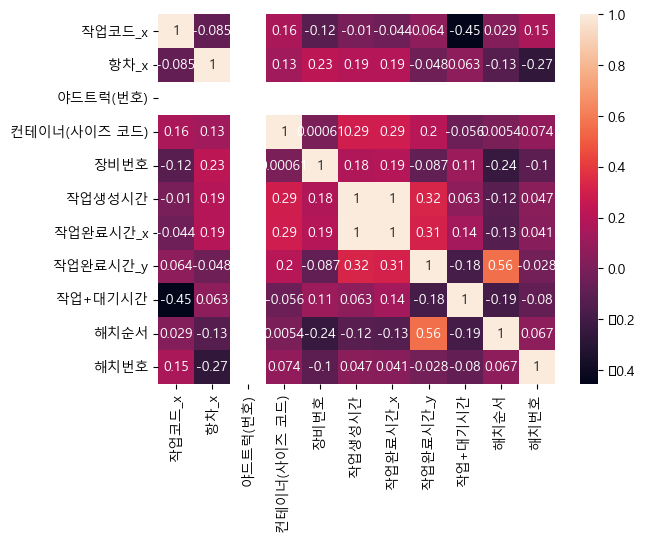

In [12]:
common_df_truck_yard = common_df[common_df['야드트럭(번호)'] != 1]
print(common_df_truck_yard.info())
common_df_truck_normal = common_df[common_df['야드트럭(번호)'] == 1]
print(common_df_truck_normal.info())
correlation_matrix = common_df_truck_normal[['작업코드_x','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간_x', '작업완료시간_y','작업+대기시간','해치순서','해치번호']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()